# IMPORT

In [289]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sympy as sy
from scipy.optimize import curve_fit
from matplotlib.lines import Line2D

# FUNCTION DEFINITIONS

In [290]:
def to_rad(x):
    return x*np.pi/180

def multiwrite(outfile, string):
    outfile.write(string + "\n")
    print(string)
    
def fit_function(theta, A, m, s, r, a, b):
    # A: normalization, m: average, 2s: FWHM of Lorentzian, r: relative ratio, a b linear parameters
    sg = s/np.sqrt(2*np.log(2)) # sigma of gaussian
    lor = A/np.pi*s/((theta-m)**2+s**2)
    gaus = A/(sg*np.sqrt(2*np.pi))*np.exp(-(theta-m)**2/(2*sg**2))
    line = a*theta+b
    return r*lor + (1-r)*gaus + line


def d(theta):
    return l/(2*np.sin(theta))

def d_err(theta, theta_err):
    return l*np.array(theta_err)/(2*np.tan(theta)*np.sin(theta))


def lattice_constant(d, h, k, l):
    return  d*np.sqrt(h**2+k**2+l**2)

def lattice_constant_err(d_err, h, k, l):
    return  d_err*np.sqrt(h**2+k**2+l**2)


def beta_size(beta_obs):
    return np.sqrt(beta_obs**2-beta_instr**2)

def beta_size_err(beta_obs, beta_obs_err):
    return beta_obs*beta_obs_err/np.sqrt(beta_obs**2-beta_instr**2)


def Scherrer(theta, beta):
    return K*l/(beta*np.cos(theta))

def Scherrer_err(theta, theta_err, beta, beta_err):
    return np.sqrt( ((K*l/(np.cos(theta)*np.array(beta)**2))**2)*np.array(beta_err)**2 + ((K*l/(np.tan(theta)*np.sin(theta)*np.array(beta)))**2)*np.array(theta_err)**2 )

# DATA

In [291]:
fs = 20 # standardize the fontsize
l = 0.15406 # [nm], from CuKa1
beta_instr = to_rad(0.27)
K = 0.89 # using FWHM

data = pd.read_csv("Group01_GIXRD1.txt", sep=" ", header=None)
data.columns = ["2theta", "intensity"]
two_theta_deg = np.array(data["2theta"]) # [deg], detector's angle
theta = np.array(data["2theta"])*np.pi/360 # [rad], Bragg's angle
intensity = np.array(data["intensity"]) #counts

# INTENSITY SPECTRUM PLOT

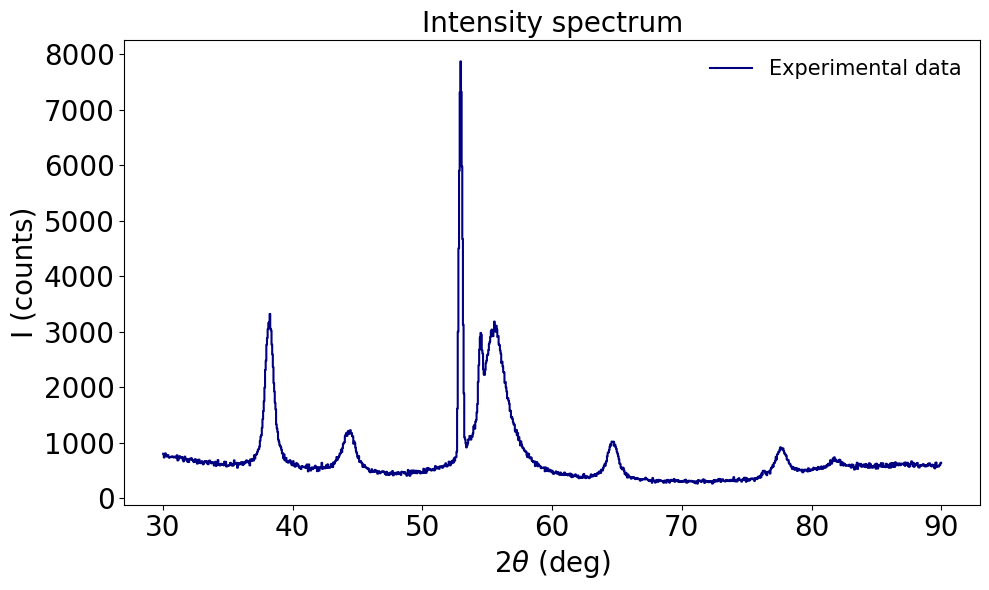

In [292]:
plt.figure(figsize=(10, 6), dpi=100)
plt.step(two_theta_deg, intensity, color="navy", label="Experimental data")
plt.title("Intensity spectrum", fontdict={"fontsize": fs})
plt.xlabel(r"$2\theta$ (deg)", fontdict={"fontsize": fs})
plt.xticks(fontsize=fs)
plt.ylabel("I (counts)", fontdict={"fontsize": fs})
plt.yticks(fontsize=fs)
plt.legend(fontsize=fs//4*3, frameon=False)
plt.tight_layout()

# FITTING

Curve fit:
A = [114.33489102441803, 47.759503728948225, 32.610981448697714, 23.605595104476997, 8.30912178651184] with errors [9.119585875757144, 3.8866628594028416, 2.8777677410595324, 5.807352534678496, 3.075086520103207]
m = [0.3336620965642248, 0.38722091099679934, 0.5646773925174935, 0.6779229863958707, 0.7143811844972145] with errors [2.3619903545664936e-05, 7.676394487097157e-05, 5.522365704414744e-05, 8.218847335717855e-05, 0.000269258365157076]
s = [0.00588461729484181, 0.009147240078341442, 0.007170379377329552, 0.007395702230230046, 0.007864681083022655] with errors [0.0002096010005643927, 0.00037329836596132585, 0.0003096787199550136, 0.0007916534233094792, 0.0014266905260179343]
FWHM = 2s = [0.01176923458968362, 0.018294480156682884, 0.014340758754659105, 0.014791404460460091, 0.01572936216604531] with errors [0.0004192020011287854, 0.0007465967319226517, 0.0006193574399100272, 0.0015833068466189584, 0.0028533810520358686]
r = [1.640926769133281, 1.6375698452058842, 1.5925

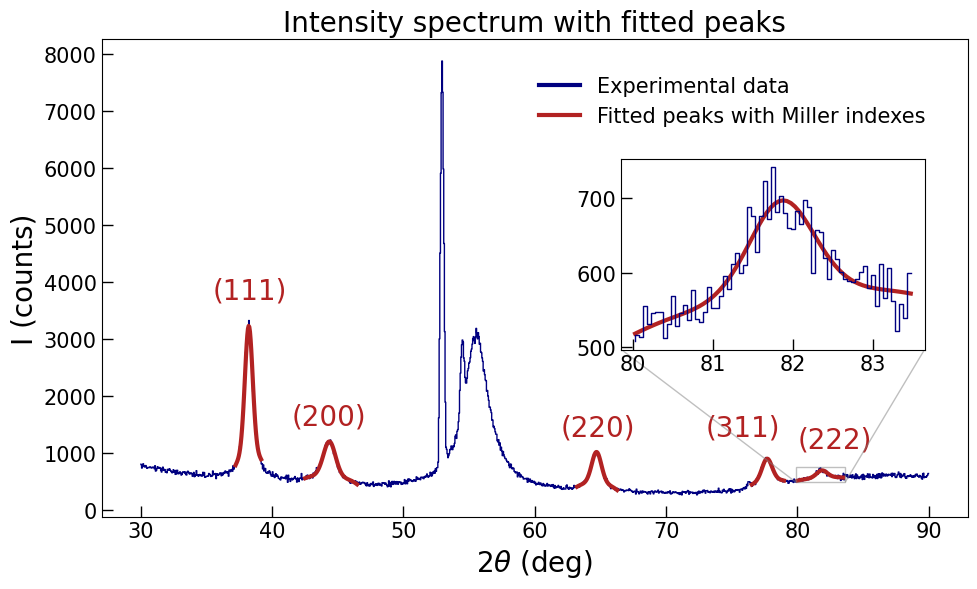

In [293]:
# creating couples of data with ranges of interest for the fits
two_theta_deg_peak1 = []
intensity_peak1 = []
two_theta_deg_peak2 = []
intensity_peak2 = []
two_theta_deg_peak3 = []
intensity_peak3 = []
two_theta_deg_peak4 = []
intensity_peak4 = []
two_theta_deg_peak5 = []
intensity_peak5 = []

for i in range(len(two_theta_deg)):
    if (two_theta_deg[i] >= 37.2 and two_theta_deg[i] <= 39.2):
        two_theta_deg_peak1.append(two_theta_deg[i])
        intensity_peak1.append(intensity[i])
    if (two_theta_deg[i] >= 42.5 and two_theta_deg[i] <= 46.5):
        two_theta_deg_peak2.append(two_theta_deg[i])
        intensity_peak2.append(intensity[i])
    if (two_theta_deg[i] >= 63.2 and two_theta_deg[i] <= 66.3):
        two_theta_deg_peak3.append(two_theta_deg[i])
        intensity_peak3.append(intensity[i])
    if (two_theta_deg[i] >= 76.5 and two_theta_deg[i] <= 79):
        two_theta_deg_peak4.append(two_theta_deg[i])
        intensity_peak4.append(intensity[i])
    if (two_theta_deg[i] >= 80 and two_theta_deg[i] <= 83.5):
        two_theta_deg_peak5.append(two_theta_deg[i])
        intensity_peak5.append(intensity[i])

# radiants conversion to use for fitting
theta_peak1 = np.array(two_theta_deg_peak1)*np.pi/360
theta_peak2 = np.array(two_theta_deg_peak2)*np.pi/360
theta_peak3 = np.array(two_theta_deg_peak3)*np.pi/360
theta_peak4 = np.array(two_theta_deg_peak4)*np.pi/360
theta_peak5 = np.array(two_theta_deg_peak5)*np.pi/360

# datas for fitting each of the 5 peaks
theta_peaks = [theta_peak1, theta_peak2, theta_peak3, theta_peak4, theta_peak5] # x data [rad]
intensity_peaks = [intensity_peak1,  intensity_peak2,  intensity_peak3,  intensity_peak4,  intensity_peak5] # y data

# initial guess for each parameter for fitting each of the 5 peaks
A_guess = [3000, 1200, 1000, 900, 800]
m_guess = np.array([19, 44, 65, 77, 82]) * np.pi / 360 # [rad]
s_guess = [0.5, 0.5, 0.5, 0.5, 0.5] # [rad]
r_guess = [0.5, 0.5, 0.5, 0.5, 0.5]
a_guess = [0, 0, 0, 0, 0]
b_guess = [700, 800, 600, -1000, 600]
bounds = ([0, 0, 0, 0, -np.inf, 0], [10000, 1, 1, 1, np.inf, 10000])

# create canvas
fig, ax = plt.subplots(figsize=(10, 6), dpi=100)

# plot all the data
ax.step(two_theta_deg, intensity, lw=1, color='navy')

FWHM = [] # this will be our beta observed (that is the sum of the beta size and beta instrumental)
FWHM_err = []
A_fit = []
A_err = []
m_fit = []
m_err = []
s_fit = []
s_err = []
r_fit = []
r_err = []
a_fit = []
a_err = []
b_fit = []
b_err = []
# unpack each array: every cycle is a fit on a peak
for x_fit, y_fit, A, m, s, r, a, b in zip(theta_peaks, intensity_peaks, A_guess, m_guess, s_guess, r_guess, a_guess, b_guess):
    # perform the fit
    par_fit, par_cov = curve_fit(fit_function, x_fit, y_fit, p0=(A, m, s, r, a, b), maxfev=5000)
    # plot each fit
    ax.plot(x_fit*360/np.pi, fit_function(x_fit, *par_fit), lw=3, color='firebrick') # pay attention, this is in [deg] just to have the plot
    # outputs
    FWHM.append(2*par_fit[2])
    FWHM_err.append(2*np.sqrt(par_cov[2,2]))
    A_fit.append(par_fit[0])
    A_err.append(np.sqrt(par_cov[0,0]))
    m_fit.append(par_fit[1])
    m_err.append(np.sqrt(par_cov[1,1]))
    s_fit.append(par_fit[2])
    s_err.append(np.sqrt(par_cov[2,2]))
    r_fit.append(par_fit[3])
    r_err.append(np.sqrt(par_cov[3,3]))
    a_fit.append(par_fit[4])
    a_err.append(np.sqrt(par_cov[4,4]))
    b_fit.append(par_fit[5])
    b_err.append(np.sqrt(par_cov[5,5]))

# labels
ax.set_title("Intensity spectrum with fitted peaks", fontdict={"fontsize": fs})
ax.set_xlabel(r"$2\theta$ (deg)", fontdict={"fontsize": fs})
ax.set_ylabel("I (counts)", fontdict={"fontsize": fs})

# writing legend by hand for fitted peaks (to avoid multiple outputs)
legend_elements = [Line2D([0], [0], color='navy', lw=3, label='Experimental data'),
                   Line2D([0], [0], color='firebrick', lw=3, label='Fitted peaks with Miller indexes')]
ax.legend(handles=legend_elements, loc=(0.495, 0.8), frameon=False, fontsize=fs//4*3)

# handling ticks
ax.tick_params(which='both', width=1.0, length=8, direction='in', labelsize=fs//4*3)

# zoom
inax = ax.inset_axes([0.6, 0.35, 0.35, 0.4])
inax.plot(theta_peak5*360/np.pi, fit_function(x_fit, *par_fit), lw=3, color='firebrick')
inax.step(theta_peak5*360/np.pi, intensity_peak5, lw=1, color='navy')
ax.indicate_inset_zoom(inax)

# handling ticks
inax.tick_params(which='both', width=1.0, length=8, direction='in', labelsize=fs//4*3)

# assign miller indexes
ax.text(35.5, 3700, '(111)', fontdict=None, fontsize = fs, color ="firebrick")
ax.text(41.5, 1500, '(200)', fontdict=None, fontsize = fs, color ="firebrick")
ax.text(62, 1300, '(220)', fontdict=None, fontsize = fs, color ="firebrick")
ax.text(73, 1300, '(311)', fontdict=None, fontsize = fs, color ="firebrick")
ax.text(80, 1100, '(222)', fontdict=None, fontsize = fs, color ="firebrick")

# manage layout and save
fig.tight_layout()

with open("outputfile2.txt", "w") as outfile:
    multiwrite(outfile, "Curve fit:")
    multiwrite(outfile, "A = " + str(A_fit) + " with errors " + str(A_err))
    multiwrite(outfile, "m = " + str(m_fit) + " with errors " + str(m_err))
    multiwrite(outfile, "s = " + str(s_fit) + " with errors " + str(s_err))
    multiwrite(outfile, "FWHM = 2s = " + str(FWHM) + " with errors " + str(FWHM_err))
    multiwrite(outfile, "r = " + str(r_fit) + " with errors " + str(r_err))
    multiwrite(outfile, "a = " + str(a_fit) + " with errors " + str(a_err))
    multiwrite(outfile, "b = " + str(b_fit) + " with errors " + str(b_err))
    multiwrite(outfile, "")

# HEIGHT OF PEAKS

In [294]:
height_with_baseline = fit_function(np.array(m_fit), np.array(A_fit), np.array(m_fit), np.array(s_fit), np.array(r_fit), np.array(a_fit), np.array(b_fit))

height = np.zeros(5)

height[0] = height_with_baseline[0] - 870
height[1] = height_with_baseline[1] - 510
height[2] = height_with_baseline[2] - 400
height[3] = height_with_baseline[3] - 470
height[4] = height_with_baseline[4] - 550

height_err = [70, 30, 20, 30, 20]

# LATTICE CONSTANT AND PARTICLE SIZE

In [295]:
# LATTICE CONSTANT

d_fit = d(m_fit)
d_fit_err = d_err(m_fit, m_err) 

latt = np.zeros(5)
latt_err = np.zeros(5)
latt[0] = lattice_constant(d_fit[0], 1, 1, 1)
latt[1] = lattice_constant(d_fit[1], 2, 0, 0)
latt[2] = lattice_constant(d_fit[2], 2, 2, 0)
latt[3] = lattice_constant(d_fit[3], 3, 1, 1)
latt[4] = lattice_constant(d_fit[4], 2, 2, 2)
latt_err[0] = lattice_constant_err(d_fit_err[0], 1, 1, 1)
latt_err[1] = lattice_constant_err(d_fit_err[1], 2, 0, 0)
latt_err[2] = lattice_constant_err(d_fit_err[2], 2, 2, 0)
latt_err[3] = lattice_constant_err(d_fit_err[3], 3, 1, 1)
latt_err[4] = lattice_constant_err(d_fit_err[4], 2, 2, 2)

latt_av = np.average(latt)
latt_av_err = np.std(latt)/np.sqrt(len(latt))

# WEIGHTED AVERAGE

# symbolic names: variables names + s for variables' errors
a1s = sy.symbols('a1s'); s_a1s = sy.symbols('s_a1s')
a2s = sy.symbols('a2s'); s_a2s = sy.symbols('s_a2s')
a3s = sy.symbols('a3s'); s_a3s = sy.symbols('s_a3s')
a4s = sy.symbols('a4s'); s_a4s = sy.symbols('s_a4s')
a5s = sy.symbols('a5s'); s_a5s = sy.symbols('s_a5s')
A1s = sy.symbols('A1s'); s_A1s = sy.symbols('s_A1s')
A2s = sy.symbols('A2s'); s_A2s = sy.symbols('s_A2s')
A3s = sy.symbols('A3s'); s_A3s = sy.symbols('s_A3s')
A4s = sy.symbols('A4s'); s_A4s = sy.symbols('s_A4s')
A5s = sy.symbols('A5s'); s_A5s = sy.symbols('s_A5s')
ys = sy.symbols("ys")

# formula
ys = (a1s*A1s + a2s*A2s + a3s*A3s + a4s*A4s + a5s*A5s) / (A1s + A2s + A3s + A4s + A5s)

# lambdify the expression
y_lam = sy.lambdify([a1s, a2s, a3s, a4s, a5s, A1s, A2s, A3s, A4s, A5s], ys, 'numpy')

# insert the numerical values
y = y_lam(*latt, *height)

# define the symbolic partial derivatives
da1s = sy.diff(ys, a1s)
da2s = sy.diff(ys, a2s)
da3s = sy.diff(ys, a3s)
da4s = sy.diff(ys, a4s)
da5s = sy.diff(ys, a5s)
dA1s = sy.diff(ys, A1s)
dA2s = sy.diff(ys, A2s)
dA3s = sy.diff(ys, A3s)
dA4s = sy.diff(ys, A4s)
dA5s = sy.diff(ys, A5s)

# error propagation formula
s_ys = sy.sqrt((da1s*s_a1s)**2 + (da2s*s_a2s)**2 + (da3s*s_a3s)**2 + (da4s*s_a4s)**2 + (da5s*s_a5s)**2 + (dA1s*s_A1s)**2 + (dA2s*s_A2s)**2 + (dA3s*s_A3s)**2 + (dA4s*s_A4s)**2 + (dA5s*s_A5s)**2)

# lamdify the expression
s_y_lam = sy.lambdify([a1s, a2s, a3s, a4s, a5s, A1s, A2s, A3s, A4s, A5s, s_a1s, s_a2s, s_a3s, s_a4s, s_a5s, s_A1s, s_A2s, s_A3s, s_A4s, s_A5s], s_ys, 'numpy')

# insert the numerical values
s_y = s_y_lam(*latt, *height, *latt_err, *height_err)



# PARTICLE SIZE

beta = []
beta_err = []
for i in range(len(FWHM)):
    beta = beta_size(FWHM[i])
    beta_err = beta_size_err(FWHM[i], FWHM_err[i])

R_v = Scherrer(m_fit, beta)/2  # volume weighted radius
R_v_err = Scherrer_err(m_fit, m_err, beta, beta_err)/2

R_v_av = np.average(R_v)
R_v_av_err = np.std(R_v)/np.sqrt(len(R_v))

# WEIGHTED AVERAGE

# symbolic names: variables names + s for [variables; errors]
r1s = sy.symbols('r1s'); s_r1s = sy.symbols('s_r1s')
r2s = sy.symbols('r2s'); s_r2s = sy.symbols('s_r2s')
r3s = sy.symbols('r3s'); s_r3s = sy.symbols('s_r3s')
r4s = sy.symbols('r4s'); s_r4s = sy.symbols('s_r4s')
r5s = sy.symbols('r5s'); s_r5s = sy.symbols('s_r5s')
A1s = sy.symbols('A1s'); s_A1s = sy.symbols('s_A1s')
A2s = sy.symbols('A2s'); s_A2s = sy.symbols('s_A2s')
A3s = sy.symbols('A3s'); s_A3s = sy.symbols('s_A3s')
A4s = sy.symbols('A4s'); s_A4s = sy.symbols('s_A4s')
A5s = sy.symbols('A5s'); s_A5s = sy.symbols('s_A5s')
zs = sy.symbols("zs")

# formula
zs = (r1s*A1s + r2s*A2s + r3s*A3s + r4s*A4s + r5s*A5s) / (A1s + A2s + A3s + A4s + A5s)

# lambdify the expression
z_lam = sy.lambdify([r1s, r2s, r3s, r4s, r5s, A1s, A2s, A3s, A4s, A5s], zs, 'numpy')

# insert the numerical values
z = z_lam(*R_v, *height)

# define the symbolic partial derivatives
dr1s = sy.diff(zs, r1s)
dr2s = sy.diff(zs, r2s)
dr3s = sy.diff(zs, r3s)
dr4s = sy.diff(zs, r4s)
dr5s = sy.diff(zs, r5s)
dA1s = sy.diff(zs, A1s)
dA2s = sy.diff(zs, A2s)
dA3s = sy.diff(zs, A3s)
dA4s = sy.diff(zs, A4s)
dA5s = sy.diff(zs, A5s)

# error propagation formula
s_zs = sy.sqrt((dr1s*s_r1s)**2 + (dr2s*s_r2s)**2 + (dr3s*s_r3s)**2 + (dr4s*s_r4s)**2 + (dr5s*s_r5s)**2 + (dA1s*s_A1s)**2 + (dA2s*s_A2s)**2 + (dA3s*s_A3s)**2 + (dA4s*s_A4s)**2 + (dA5s*s_A5s)**2)

# lamdify the expression
s_z_lam = sy.lambdify([r1s, r2s, r3s, r4s, r5s, A1s, A2s, A3s, A4s, A5s, s_r1s, s_r2s, s_r3s, s_r4s, s_r5s, s_A1s, s_A2s, s_A3s, s_A4s, s_A5s], s_zs, 'numpy')

# insert the numerical values
s_z = s_z_lam(*R_v, *height, *R_v_err, *height_err)




# OUTPUTS

with open("outputfile2.txt", "a") as outfile:
    multiwrite(outfile, "lattice constants = " + str(latt) + " nm with errors " + str(latt_err) + " nm" )
    multiwrite(outfile, "lattice constant average = " + str(latt_av) + " nm with error " + str(latt_av_err) + " nm" )
    multiwrite(outfile, "lattice constant weighted average= " + str(y) + " nm with error " + str(s_y) + " nm" )
    multiwrite(outfile, "volumic radii = " + str(R_v) + " nm with errors " + str(R_v_err) + " nm" )
    multiwrite(outfile, "volumic radius average = " + str(R_v_av) + " nm with error " + str(R_v_av_err) + " nm" )
    multiwrite(outfile, "volumic radius weighted average = " + str(z) + " nm with error " + str(s_z) + " nm" )
    multiwrite(outfile, "")


lattice constants = [0.40738228 0.40798    0.40713157 0.40734873 0.40729564] nm with errors [2.77603166e-05 7.67959545e-05 3.54914583e-05 4.15773030e-05
 1.26465475e-04] nm
lattice constant average = 0.40742764442978247 nm with error 0.00012937866043146327 nm
lattice constant weighted average= 0.4074368000341431 nm with error 2.1824456277049187e-05 nm
volumic radii = [4.8350075  4.93362931 5.40786333 5.86530771 6.04680452] nm with errors [0.96358018 0.98323692 1.07774572 1.16891084 1.20508346] nm
volumic radius average = 5.417722474868461 nm with error 0.21634018590674023 nm
volumic radius weighted average = 5.081285539152323 nm with error 0.5934647395457802 nm

